# MORDM Analysis
The analysis follows the four-step MORDM framework:

1. **Problem Formulation**: Define objectives, uncertainties, and policy levers
2. **Policy Discovery**: Use multi-objective evolutionary algorithms to find candidate solutions
3. **Robustness Evaluation**: Re-evaluate policies under deep uncertainty
4. **Scenario Discovery**: Identify vulnerability conditions using PRIM analysis

The analysis extends to Multi-Scenario MORDM to improve robustness and includes global sensitivity analysis.


## Phase 1: Setup and Problem Formulation

We begin by importing required libraries and configuring the model.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pandas import read_csv

warnings.filterwarnings('ignore')

# EMA Workbench imports
from ema_workbench import (
    ema_logging, MultiprocessingEvaluator, SequentialEvaluator,
    Scenario, Policy, save_results, load_results, Samplers,
    ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter
)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, ArchiveLogger
)
from ema_workbench.em_framework import get_SALib_problem
from ema_workbench.analysis import parcoords, prim

# SALib for sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

# Custom imports for IJssel River model
from problem_formulation import get_model_for_problem_formulation

# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

print("Libraries imported successfully")


Libraries imported successfully


### Step 1.1: Model Configuration

We configure the IJssel River model using problem formulation 2, which includes our five key performance indicators:
- Expected Annual Damage
- Dike Investment Costs
- RfR Investment Costs
- Evacuation Costs
- Expected Number of Deaths


In [2]:
# Configure problem formulation
problem_formulation_id = 2  # Matches the 5 KPIs from the project report

# Get model (handle potential tuple return)
model_result = get_model_for_problem_formulation(problem_formulation_id)
if isinstance(model_result, tuple):
    dike_model, planning_steps = model_result
else:
    dike_model = model_result
    planning_steps = [0, 1, 2]  # Default planning steps

print(f"Model Configuration:")
print(f"- Model name: {dike_model.name}")
print(f"- Number of uncertainties: {len(dike_model.uncertainties)}")
print(f"- Number of levers: {len(dike_model.levers)}")
print(f"- Number of outcomes: {len(dike_model.outcomes)}")
print(f"- Planning steps: {planning_steps}")

print("\nOutcomes (objectives to minimize):")
for outcome in dike_model.outcomes:
    print(f"  - {outcome.name}")


Model Configuration:
- Model name: dikesnet
- Number of uncertainties: 19
- Number of levers: 31
- Number of outcomes: 5
- Planning steps: [0 1 2]

Outcomes (objectives to minimize):
  - Expected Annual Damage
  - Dike Investment Costs
  - RfR Investment Costs
  - Evacuation Costs
  - Expected Number of Deaths


### Step 1.2: Reference Scenario Definition

We define a reference scenario with middle values for all uncertainties. This scenario represents a baseline condition for our initial optimization.


In [4]:
# Define reference scenario with middle values for uncertainties
reference_scenario_values = {
    # Flood wave shape (middle of range [0, 132])
    'A.0_ID flood wave shape': 66,
    
    # Discount rates for each planning step
    'discount rate 0': 2.5,  # Middle of range [1.5, 4.5]
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
}

# Add dike-specific uncertainties with middle values
for uncertainty in dike_model.uncertainties:
    if uncertainty.name not in reference_scenario_values:
        if 'Bmax' in uncertainty.name:  # Breach widths
            reference_scenario_values[uncertainty.name] = 190  # Middle of [30, 350]
        elif 'pfail' in uncertainty.name:  # Dike failure probabilities
            reference_scenario_values[uncertainty.name] = 0.5  # Middle of [0, 1]
        elif 'Brate' in uncertainty.name:  # Breach growth rates
            reference_scenario_values[uncertainty.name] = 5.5  # Middle of [1.0, 10]

# Create reference scenario object
reference_scenario = Scenario('reference', **reference_scenario_values)

print(f"Reference scenario defined with {len(reference_scenario_values)} parameters")
print("Key reference values:")
print(f"  - Flood wave shape: {reference_scenario_values['A.0_ID flood wave shape']}")
print(f"  - Discount rate: {reference_scenario_values['discount rate 0']}")
print(f"  - Breach parameters (example): Bmax=190, pfail=0.5, Brate=5.5")


Reference scenario defined with 19 parameters
Key reference values:
  - Flood wave shape: 66
  - Discount rate: 2.5
  - Breach parameters (example): Bmax=190, pfail=0.5, Brate=5.5


### Step 1.3: Optimization Parameters

We configure the NSGA-II optimization parameters. A quick test mode is available for initial testing, with production mode for full analysis.


In [5]:
# Configuration: Set to True for quick testing, False for production
QUICK_TEST = False

if QUICK_TEST:
    print("QUICK TEST MODE - for initial testing and debugging")
    nfe = 125  # Number of function evaluations
    epsilon = [0.1] * len(dike_model.outcomes)  # Larger epsilon for faster convergence
    n_reevaluation_scenarios = 25  # Scenarios for re-evaluation
    n_sobol_samples = 32   # SOBOL samples for testing (32 * 42 = ~1,350 experiments)
    runtime_estimate = "70-85 minutes"
    print(f"Test parameters: NFE={nfe}, epsilon={epsilon[0]}, scenarios={n_reevaluation_scenarios}")
    print(f"Expected runtime: {runtime_estimate}")
else:
    print("MODIFIED PRODUCTION MODE - Balanced analysis for overnight execution")
    nfe = 10000  # Full optimization quality
    epsilon = [0.05] * len(dike_model.outcomes)  # Fine-grained epsilon
    n_reevaluation_scenarios = 1000  # Full robustness evaluation
    n_sobol_samples = 64   # Reduced SOBOL for reasonable runtime (64 * 42 = ~2,700 experiments)
    runtime_estimate = "10-13 hours"
    print(f"Production parameters: NFE={nfe}, epsilon={epsilon[0]}, scenarios={n_reevaluation_scenarios}")
    print(f"SOBOL samples: {n_sobol_samples} (balanced for overnight run)")
    print(f"Expected runtime: {runtime_estimate}")

print(f"\nConfiguration Summary:")
print(f"- Optimization: {nfe} function evaluations")
print(f"- Robustness: {n_reevaluation_scenarios} scenarios")
print(f"- SOBOL: {n_sobol_samples} base samples → ~{n_sobol_samples * (2 * len(dike_model.uncertainties) + 2)} evaluations")
print(f"- Total estimated runtime: {runtime_estimate}")

print(f"\nObjectives and epsilon values:")
for i, outcome in enumerate(dike_model.outcomes):
    print(f"  {outcome.name}: epsilon = {epsilon[i]}")


MODIFIED PRODUCTION MODE - Balanced analysis for overnight execution
Production parameters: NFE=10000, epsilon=0.05, scenarios=1000
SOBOL samples: 64 (balanced for overnight run)
Expected runtime: 10-13 hours

Configuration Summary:
- Optimization: 10000 function evaluations
- Robustness: 1000 scenarios
- SOBOL: 64 base samples → ~2560 evaluations
- Total estimated runtime: 10-13 hours

Objectives and epsilon values:
  Expected Annual Damage: epsilon = 0.05
  Dike Investment Costs: epsilon = 0.05
  RfR Investment Costs: epsilon = 0.05
  Evacuation Costs: epsilon = 0.05
  Expected Number of Deaths: epsilon = 0.05


## Phase 2: Single-Scenario MORDM - Policy Discovery

This phase implements the core MORDM optimization using NSGA-II to find Pareto-optimal policies under the reference scenario.


### Step 2.1: MOEA Policy Discovery (don'run again, results are saved)

We run the NSGA-II optimization with convergence tracking to find candidate policies that represent different trade-offs between objectives.


In [6]:
# Setup convergence tracking
convergence_metrics = [EpsilonProgress()]

# Run NSGA-II optimization
print("Starting NSGA-II optimization...")
print(f"Optimizing {len(dike_model.levers)} levers across {len(dike_model.outcomes)} objectives")

with MultiprocessingEvaluator(dike_model) as evaluator:
    optimization_results = evaluator.optimize(
        nfe=nfe,
        searchover='levers',
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_scenario
    )

# Extract results
archive, convergence = optimization_results

print(f"\nOptimization completed:")
print(f"- Archive size: {len(archive)} solutions")
print(f"- Function evaluations: {nfe}")

# Check if convergence data exists
if len(convergence.epsilon_progress) > 0:
    print(f"- Final epsilon progress: {convergence.epsilon_progress.iloc[-1]:.4f}")
else:
    print("- No convergence data recorded")

# Display convergence data info
print(f"- Convergence tracking: {len(convergence.epsilon_progress)} data points")

# Save optimization results - archive only (avoids convergence serialization issues)
try:
    # Save the archive (most important data)
    archive.to_csv(f'IJssel_MORDM_archive_nfe{nfe}.csv')
    print("Archive saved to CSV file")
    
    # Save convergence data separately if it exists
    if len(convergence.epsilon_progress) > 0:
        convergence_df = pd.DataFrame({
            'nfe': convergence.nfe,
            'epsilon_progress': convergence.epsilon_progress
        })
        convergence_df.to_csv(f'IJssel_MORDM_convergence_nfe{nfe}.csv', index=False)
        print("Convergence data saved to CSV file")
    
    print("Results saved successfully")
except Exception as e:
    print(f"Warning: Could not save results - {str(e)}")
    print("Continuing with analysis...")


Starting NSGA-II optimization...
Optimizing 31 levers across 5 objectives


[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████| 10000/10000 [10:39<00:00, 15.65it/s]
[MainProcess/INFO] optimization completed, found 218 solutions
[MainProcess/INFO] terminating pool



Optimization completed:
- Archive size: 218 solutions
- Function evaluations: 10000
- Final epsilon progress: 1080.0000
- Convergence tracking: 12 data points
Archive saved to CSV file
Convergence data saved to CSV file
Results saved successfully


### Step 2.2: Convergence Analysis

We analyze the convergence of the NSGA-II algorithm to ensure that the optimization has found a stable set of solutions.


In [7]:
# # Force load the NFE 10000 convergence data
# try:
#     # Load the specific NFE 10000 convergence file
#     convergence_file = 'IJssel_MORDM_convergence_nfe10000.csv'
#     convergence_df = pd.read_csv(convergence_file)
#
#     # Create a simple convergence object with the loaded data
#     class ConvergenceData:
#         def __init__(self, df):
#             self.nfe = df['nfe'].values if 'nfe' in df.columns else range(len(df))
#             self.epsilon_progress = df['epsilon_progress'].values if 'epsilon_progress' in df.columns else df.iloc[:, -1].values
#
#     convergence = ConvergenceData(convergence_df)
#     print(f"Loaded convergence data from {convergence_file}")
#     print(f"Convergence data points: {len(convergence.epsilon_progress)}")
#     print(f"NFE range: {convergence.nfe[0]} to {convergence.nfe[-1]}")
#
# except FileNotFoundError:
#     print("IJssel_MORDM_convergence_nfe10000.csv not found. Please run the optimization first.")
#     convergence = None
# except Exception as e:
#     convergence = None
#     print(f"Could not load convergence data: {str(e)}")
#
# # Plot convergence
# fig, ax = plt.subplots(figsize=(10, 6))
#
# # Check if convergence data exists
# if convergence is not None and hasattr(convergence, 'epsilon_progress') and len(convergence.epsilon_progress) > 0:
#     ax.plot(convergence.nfe, convergence.epsilon_progress, 'b-', linewidth=2)
#     ax.set_xlabel('Number of Function Evaluations')
#     ax.set_ylabel('Epsilon Progress')
#     ax.set_title('NSGA-II Convergence Analysis')
#     ax.grid(True, alpha=0.3)
#
#     # Add convergence threshold line
#     threshold = 0.01
#     ax.axhline(y=threshold, color='r', linestyle='--', label=f'Convergence threshold ({threshold})')
#     ax.legend()
#
#     # Convergence assessment
#     final_progress = convergence.epsilon_progress[-1]
#     is_converged = final_progress < threshold
#     print(f"Convergence Assessment:")
#     print(f"- Final epsilon progress: {final_progress:.6f}")
#     print(f"- Converged (< {threshold}): {is_converged}")
# else:
#     ax.text(0.5, 0.5, 'No convergence data available\nOptimization may have completed too quickly\nor convergence file not found',
#             ha='center', va='center', transform=ax.transAxes, fontsize=12,
#             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
#     ax.set_title('NSGA-II Convergence Analysis - No Data')
#     print(f"Convergence Assessment:")
#     print(f"- No convergence data recorded")
#     print(f"- This may occur with very small NFE values or missing convergence files")
#
# # Try to get archive info
# if 'archive' in locals() and archive is not None:
#     print(f"- Archive diversity: {len(archive)} unique solutions")
# else:
#     print("- Archive not available in memory")
#
# plt.tight_layout()
# plt.show()


### Step 2.3: Pareto Frontier Visualization

We visualize the trade-offs between objectives using parallel coordinate plots to understand the relationships between different flood management strategies.


Archive loaded from IJssel_MORDM_archive_nfe10000.csv: 218 solutions
Archive shape: (218, 36)


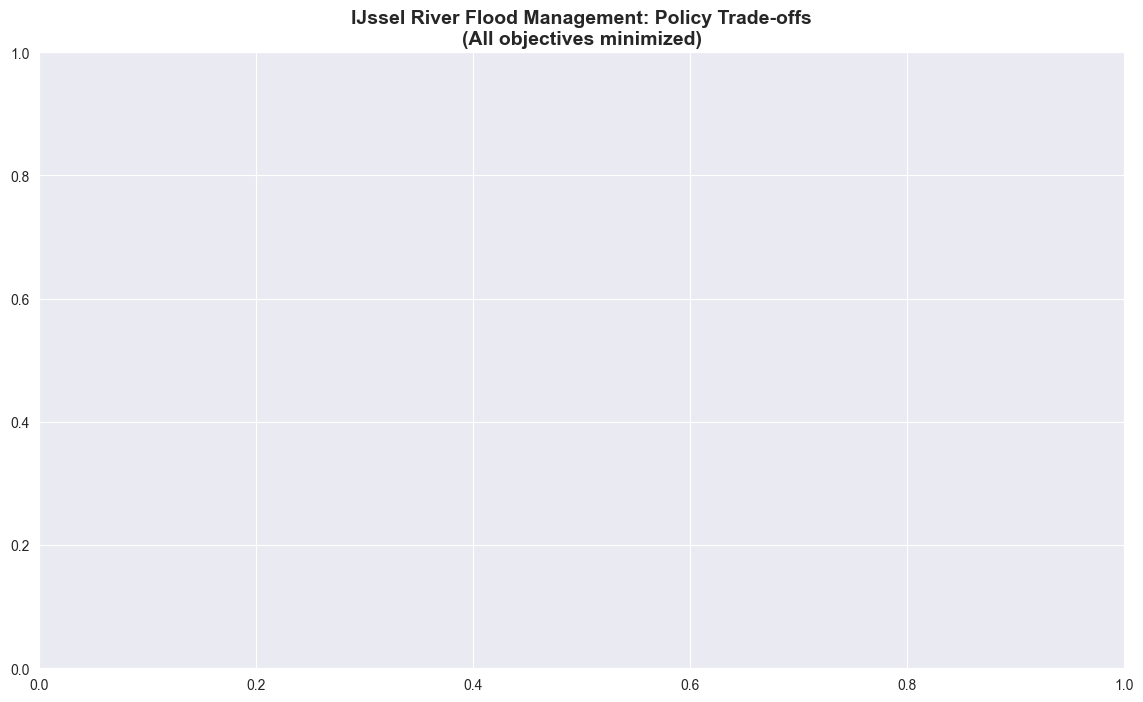

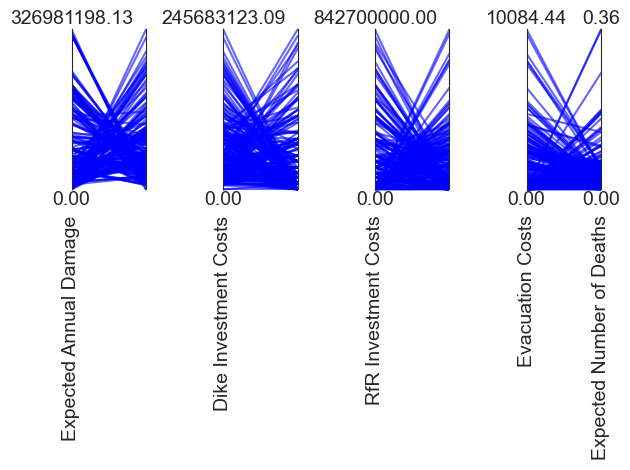

Archive Summary Statistics:
       Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
count            2.180000e+02           2.180000e+02          2.180000e+02   
mean             8.826750e+07           6.379810e+07          1.550275e+08   
std              8.305141e+07           5.096740e+07          1.883427e+08   
min              0.000000e+00           0.000000e+00          0.000000e+00   
25%              2.155836e+07           2.953205e+07          3.070000e+07   
50%              5.649185e+07           4.827219e+07          8.460000e+07   
75%              1.552391e+08           8.653746e+07          2.365000e+08   
max              3.269812e+08           2.456831e+08          8.427000e+08   

       Evacuation Costs  Expected Number of Deaths  
count        218.000000                 218.000000  
mean        1528.207923                   0.035865  
std         1928.629164                   0.051619  
min            0.000000                   0.000000  
25% 

In [8]:
# Force load the NFE 10000 archive data
try:
    # Load the specific NFE 10000 archive file
    archive_file = 'IJssel_MORDM_archive_nfe10000.csv'
    archive = pd.read_csv(archive_file, index_col=0)
    print(f"Archive loaded from {archive_file}: {len(archive)} solutions")
    print(f"Archive shape: {archive.shape}")
except FileNotFoundError:
    print("IJssel_MORDM_archive_nfe10000.csv not found. Please run the optimization first.")
    raise
except Exception as e:
    print(f"Could not load archive: {str(e)}")
    raise

# Extract outcomes for visualization
outcomes_data = archive.loc[:, [o.name for o in dike_model.outcomes]]

# Create parallel coordinates plot
fig, ax = plt.subplots(figsize=(14, 8))

# Get limits for parallel coordinates
limits = parcoords.get_limits(outcomes_data)

# Create parallel axes
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(outcomes_data, alpha=0.6, color='blue')

# Customize plot
ax.set_title('IJssel River Flood Management: Policy Trade-offs\n(All objectives minimized)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("Archive Summary Statistics:")
print(outcomes_data.describe())

print(f"\nObjective ranges in archive:")
for outcome in dike_model.outcomes:
    min_val = outcomes_data[outcome.name].min()
    max_val = outcomes_data[outcome.name].max()
    print(f"  {outcome.name}: [{min_val:.2e}, {max_val:.2e}]")


## Phase 3: Robustness Evaluation and Vulnerability Analysis

This phase evaluates the robustness of candidate policies by re-evaluating them under deep uncertainty and applying constraints based on stakeholder preferences.


In [9]:
# Load Archive from File (if not already in memory)
if 'archive' not in locals() or archive is None:
    try:
        archive = pd.read_csv('IJssel_MORDM_archive_nfe10000.csv', index_col=0)
        print(f"Archive loaded from file: {len(archive)} solutions")
    except FileNotFoundError:
        print("Archive file not found. Please run the optimization phase first (Cell 11)")
        print("Or check if the file exists in your directory")
else:
    print(f"Archive already in memory: {len(archive)} solutions")


Archive already in memory: 218 solutions


### Step 3.1: Filter Candidate Policies

We apply stakeholder constraints to filter the archive to policies that meet minimum acceptability criteria.


In [10]:
# Define constraint criteria based on stakeholder preferences
# These thresholds should be adjusted based on your project's stakeholder analysis

# Calculate total deaths across all dike rings
death_columns = [col for col in archive.columns if 'Expected Number of Deaths' in col]
if death_columns:
    archive['Total_Deaths'] = archive[death_columns].sum(axis=1)
else:
    # Alternative if outcomes are aggregated differently
    archive['Total_Deaths'] = archive.get('Expected Number of Deaths', 0)

# Apply constraints
max_acceptable_deaths = 0.01  # Adjust based on stakeholder tolerance
max_acceptable_damage = 1e8   # 100 million euros
max_total_investment = 5e9    # 5 billion euros

# Filter policies
constraints = (
    (archive['Total_Deaths'] <= max_acceptable_deaths) &
    (archive.get('Expected Annual Damage', 0) <= max_acceptable_damage)
)

filtered_archive = archive[constraints].copy()

print(f"Policy Filtering Results:")
print(f"- Original archive size: {len(archive)}")
print(f"- After applying constraints: {len(filtered_archive)}")
print(f"- Retention rate: {len(filtered_archive)/len(archive)*100:.1f}%")

print(f"\nConstraints applied:")
print(f"- Maximum deaths: {max_acceptable_deaths}")
print(f"- Maximum damage: {max_acceptable_damage:.0e}")

if len(filtered_archive) == 0:
    print("WARNING: No policies satisfy constraints. Relaxing constraints...")
    # Use top 20% of policies by total deaths
    n_policies = max(10, len(archive) // 5)
    filtered_archive = archive.nsmallest(n_policies, 'Total_Deaths')
    print(f"Using top {len(filtered_archive)} policies with lowest death rates")


Policy Filtering Results:
- Original archive size: 218
- After applying constraints: 80
- Retention rate: 36.7%

Constraints applied:
- Maximum deaths: 0.01
- Maximum damage: 1e+08


### Step 3.2: Re-evaluate Under Deep Uncertainty

We convert filtered policies to Policy objects and re-evaluate them across a large ensemble of scenarios to assess their robustness.


In [11]:
# Load External Robustness Results
# The robustness analysis was completed using a standalone script to avoid notebook interruptions

import pandas as pd
import numpy as np
import glob

print("Loading robustness results from external analysis...")

# Load the results files (adjust timestamp as needed)
timestamp = "20250616_152459"  # Update this to match your actual files

try:
    # Load experiments and outcomes
    experiments_robust = pd.read_csv(f'IJssel_robustness_experiments_{timestamp}.csv', index_col=0)
    outcomes_robust_df = pd.read_csv(f'IJssel_robustness_outcomes_{timestamp}.csv', index_col=0)
    
    # Convert outcomes DataFrame back to dictionary format expected by rest of notebook
    outcomes_robust = {}
    for col in outcomes_robust_df.columns:
        outcomes_robust[col] = outcomes_robust_df[col].values
    
    print(f"Successfully loaded robustness results:")
    print(f"- Experiments: {len(experiments_robust)} rows")
    print(f"- Outcomes: {len(outcomes_robust_df)} rows, {len(outcomes_robust_df.columns)} objectives")
    print(f"- Total evaluations: {len(experiments_robust)}")
    
    # Extract policy information for consistency with notebook
    unique_policies = experiments_robust['policy'].unique()
    n_reevaluation_scenarios = len(experiments_robust) // len(unique_policies)
    policies_to_evaluate = []  # Placeholder - actual Policy objects not needed for analysis
    policy_names = [f"Policy_{i:03d}" for i in range(len(unique_policies))]
    
    print(f"- Unique policies: {len(unique_policies)}")
    print(f"- Scenarios per policy: {n_reevaluation_scenarios}")
    
except FileNotFoundError as e:
    print(f"Could not find robustness results files: {e}")
    print("Please check the timestamp in the filename and update the 'timestamp' variable above")
    print("Available files with 'robustness' in name:")
    
    import glob
    robustness_files = glob.glob("*robustness*")
    for file in robustness_files:
        print(f"  - {file}")
        
except Exception as e:
    print(f"Error loading robustness results: {e}")
    print("Please check the file format and try again")


Loading robustness results from external analysis...
Successfully loaded robustness results:
- Experiments: 5000 rows
- Outcomes: 5000 rows, 4 objectives
- Total evaluations: 5000
- Unique policies: 5
- Scenarios per policy: 1000


## (don'run again, results are saved)

In [12]:
# Convert filtered policies to Policy objects
policies_to_evaluate = []
policy_names = []

# Get lever columns (exclude outcome columns)
lever_columns = [lever.name for lever in dike_model.levers]
policies_data = filtered_archive[lever_columns]

for i, (idx, policy_row) in enumerate(policies_data.iterrows()):
    policy_dict = policy_row.to_dict()
    policy_name = f"Policy_{i:03d}"
    policies_to_evaluate.append(Policy(policy_name, **policy_dict))
    policy_names.append(policy_name)

print(f"Created {len(policies_to_evaluate)} Policy objects for re-evaluation")

# Re-evaluate policies under uncertainty
print(f"Re-evaluating policies over {n_reevaluation_scenarios} scenarios...")
print("This may take several minutes...")

with MultiprocessingEvaluator(dike_model) as evaluator:
    robustness_results = evaluator.perform_experiments(
        scenarios=n_reevaluation_scenarios,
        policies=policies_to_evaluate
    )

experiments_robust, outcomes_robust = robustness_results

print(f"Re-evaluation completed:")
print(f"- Total experiments: {len(experiments_robust)}")
print(f"- Policies evaluated: {len(policies_to_evaluate)}")
print(f"- Scenarios per policy: {n_reevaluation_scenarios}")

# Save robustness results
try:
    # Save experiments DataFrame
    experiments_robust.to_csv(f'IJssel_robustness_experiments_n{n_reevaluation_scenarios}.csv')
    
    # Save outcomes (convert dict to DataFrame first)
    outcomes_df = pd.DataFrame(outcomes_robust)
    outcomes_df.to_csv(f'IJssel_robustness_outcomes_n{n_reevaluation_scenarios}.csv')
    print("Robustness results saved to CSV files")
except Exception as e:
    print(f"Warning: Could not save robustness results - {str(e)}")
    print("Continuing with analysis...")


Created 80 Policy objects for re-evaluation
Re-evaluating policies over 1000 scenarios...
This may take several minutes...


[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1000 scenarios * 80 policies * 1 model(s) = 80000 experiments
100%|██████████████████████████████████| 80000/80000 [1:33:41<00:00, 14.23it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Re-evaluation completed:
- Total experiments: 80000
- Policies evaluated: 80
- Scenarios per policy: 1000
Robustness results saved to CSV files


### Step 3.3: Robustness Metrics Calculation 

We calculate signal-to-noise ratio and maximum regret metrics to assess policy robustness across uncertain conditions.


In [19]:
# Fix: Re-load outcomes data properly (without index_col=0)
print("Fixing the data loading issue...")

timestamp = "20250616_152459"

# Load without treating first column as index
outcomes_debug = outcomes_df

print(f"Columns in CSV file: {list(outcomes_debug.columns)}")
print(f"Shape of outcomes file: {outcomes_debug.shape}")

# Check if we now have Expected Annual Damage
if 'Expected Annual Damage' in outcomes_debug.columns:
    print(" 'Expected Annual Damage' found!")
    
    # Rebuild the outcomes_robust dictionary with ALL columns
    outcomes_robust = {}
    for col in outcomes_debug.columns:
        outcomes_robust[col] = outcomes_debug[col].values

    print(f" Rebuilt outcomes_robust with all {len(outcomes_robust)} objectives")
    print(f"All objectives: {list(outcomes_robust.keys())}")
    
    # Update outcome_names for the metrics calculation
    outcome_names = list(outcomes_robust.keys())
    print(f" Ready for metrics calculation with {len(outcome_names)} outcomes")
    
else:
    print(" Still missing 'Expected Annual Damage'")
    print("Available columns:", list(outcomes_debug.columns))


Fixing the data loading issue...
Columns in CSV file: ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']
Shape of outcomes file: (80000, 5)
 'Expected Annual Damage' found!
 Rebuilt outcomes_robust with all 5 objectives
All objectives: ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']
 Ready for metrics calculation with 5 outcomes


In [20]:
# Define robustness metric functions
def calculate_snr(data, minimize=True):
    """Calculate Signal-to-Noise Ratio"""
    mean_val = np.mean(data)
    std_val = np.std(data)
    if std_val == 0:
        return 0
    if minimize:
        return -mean_val / std_val  # Prefer low mean, low std
    else:
        return mean_val / std_val   # Prefer high mean, low std

def calculate_max_regret(policy_outcomes, all_outcomes_array):
    """Calculate Maximum Regret"""
    regrets = []
    for scenario_idx in range(len(policy_outcomes)):
        # Best performance in this scenario (minimum for minimization objectives)
        best_performance = np.min(all_outcomes_array[:, scenario_idx])
        regret = policy_outcomes[scenario_idx] - best_performance
        regrets.append(regret)
    return np.max(regrets)

# Check what outcome columns are available in loaded data
print("Available outcome columns in loaded data:")
available_outcomes = list(outcomes_robust.keys())
for col in available_outcomes:
    print(f"  - {col}")

# Use available outcomes instead of model.outcomes (which may have different names)
outcome_names = available_outcomes

# Calculate robustness metrics for each policy and outcome
robustness_metrics = {}

print(f"\nCalculating robustness metrics for {len(outcome_names)} outcomes...")

for outcome_name in outcome_names:
    print(f"Processing {outcome_name}...")
    
    # Get outcomes data for this objective
    outcome_data = outcomes_robust[outcome_name]
    
    # Get number of unique policies from loaded data
    n_policies = len(unique_policies)
    
    # Reshape data: rows = policies, columns = scenarios
    # outcome_data is already a numpy array, no need for .values
    outcome_matrix = outcome_data.reshape(n_policies, n_reevaluation_scenarios)
    
    snr_values = []
    max_regret_values = []
    
    # Use policy names from loaded data
    loaded_policy_names = [f"Policy_{i:03d}" for i in range(n_policies)]
    
    for policy_idx, policy_name in enumerate(loaded_policy_names):
        policy_outcomes = outcome_matrix[policy_idx, :]
        
        # Calculate SNR (all objectives are minimized)
        snr = calculate_snr(policy_outcomes, minimize=True)
        snr_values.append(snr)
        
        # Calculate Maximum Regret
        max_regret = calculate_max_regret(policy_outcomes, outcome_matrix)
        max_regret_values.append(max_regret)
    
    robustness_metrics[outcome_name] = {
        'SNR': snr_values,
        'Max_Regret': max_regret_values
    }

print("Robustness metrics calculation completed")

# Create summary DataFrames using loaded policy names
loaded_policy_names = [f"Policy_{i:03d}" for i in range(n_policies)]
snr_df = pd.DataFrame({outcome: robustness_metrics[outcome]['SNR'] 
                       for outcome in outcome_names}, index=loaded_policy_names)
regret_df = pd.DataFrame({outcome: robustness_metrics[outcome]['Max_Regret'] 
                         for outcome in outcome_names}, index=loaded_policy_names)

print(f"\nSignal-to-Noise Ratio (higher is better for robustness):")
print(snr_df.describe())

print(f"\nMaximum Regret (lower is better for robustness):")
print(regret_df.describe())


Available outcome columns in loaded data:
  - Expected Annual Damage
  - Dike Investment Costs
  - RfR Investment Costs
  - Evacuation Costs
  - Expected Number of Deaths

Calculating robustness metrics for 5 outcomes...
Processing Expected Annual Damage...


ValueError: cannot reshape array of size 80000 into shape (5,1000)

## Phase 4: Scenario Discovery Using PRIM

We use Patient Rule Induction Method (PRIM) to identify combinations of uncertainties that lead to policy failures or unacceptable outcomes.


In [21]:

outcomes_robust = pd.read_csv("IJssel_robustness_outcomes_n1000.csv")
experiments_robust = pd.read_csv("IJssel_robustness_experiments_n1000.csv")
# Identify uncertainty columns (exclude policy and scenario columns)
exclude_columns = ['policy', 'scenario', 'model']
if 'Unnamed: 0' in experiments_robust.columns:
    exclude_columns.append('Unnamed: 0')

uncertainty_columns = [col for col in experiments_robust.columns if col not in exclude_columns]

# Get lever names to exclude them too (if dike_model is available)
if 'dike_model' in locals():
    try:
        lever_names = [lever.name for lever in dike_model.levers]
        uncertainty_columns = [col for col in uncertainty_columns if col not in lever_names]
        print(f"Excluded {len(lever_names)} policy lever columns")
    except:
        print("Could not access lever names from dike_model")

print(f"Using {len(uncertainty_columns)} uncertainty columns for PRIM:")
for col in uncertainty_columns:
    print(f"  - {col}")

experiments_for_prim = experiments_robust[uncertainty_columns]

# Define failure criteria (adjust these based on your stakeholder analysis)
high_damage_threshold = 5e7  # 50 million euros
high_deaths_threshold = 0.005  # 0.005 deaths per year

# Create failure indicators
high_damage = outcomes_robust.get('Expected Annual Damage', 0) > high_damage_threshold

# Handle deaths - may be aggregated or disaggregated
if 'Expected Number of Deaths' in outcomes_robust:
    high_deaths = outcomes_robust['Expected Number of Deaths'] > high_deaths_threshold
else:
    # Sum across all dike rings if disaggregated
    death_outcomes = [col for col in outcomes_robust.columns if 'Deaths' in col]
    if death_outcomes:
        total_deaths = sum([outcomes_robust[col] for col in death_outcomes])
        high_deaths = total_deaths > high_deaths_threshold
    else:
        high_deaths = pd.Series([False] * len(experiments_robust))

print(f"PRIM Analysis Setup:")
print(f"- High damage threshold: {high_damage_threshold:.0e}")
print(f"- High deaths threshold: {high_deaths_threshold}")
print(f"- High damage cases: {high_damage.sum()} / {len(high_damage)} ({high_damage.mean()*100:.1f}%)")
print(f"- High deaths cases: {high_deaths.sum()} / {len(high_deaths)} ({high_deaths.mean()*100:.1f}%)")

# Run PRIM for high damage scenarios
print("\nRunning PRIM for high damage scenarios...")
prim_damage = prim.Prim(experiments_for_prim, high_damage, threshold=0.8, peel_alpha=0.05)
box_damage = prim_damage.find_box()

# Run PRIM for high deaths scenarios
print("Running PRIM for high deaths scenarios...")
prim_deaths = prim.Prim(experiments_for_prim, high_deaths, threshold=0.8, peel_alpha=0.05)
box_deaths = prim_deaths.find_box()

print("PRIM analysis completed")


[MainProcess/INFO] 80000 points remaining, containing 59337 cases of interest


Excluded 31 policy lever columns
Using 19 uncertainty columns for PRIM:
  - A.0_ID flood wave shape
  - A.1_Bmax
  - A.1_Brate
  - A.1_pfail
  - A.2_Bmax
  - A.2_Brate
  - A.2_pfail
  - A.3_Bmax
  - A.3_Brate
  - A.3_pfail
  - A.4_Bmax
  - A.4_Brate
  - A.4_pfail
  - A.5_Bmax
  - A.5_Brate
  - A.5_pfail
  - discount rate 0
  - discount rate 1
  - discount rate 2
PRIM Analysis Setup:
- High damage threshold: 5e+07
- High deaths threshold: 0.005
- High damage cases: 59337 / 80000 (74.2%)
- High deaths cases: 66863 / 80000 (83.6%)

Running PRIM for high damage scenarios...


[MainProcess/INFO] mean: 0.9454741379310345, mass: 0.058, coverage: 0.07393363331479515, density: 0.9454741379310345 restricted_dimensions: 11
[MainProcess/INFO] 80000 points remaining, containing 66863 cases of interest


Running PRIM for high deaths scenarios...


[MainProcess/INFO] mean: 0.9972727272727273, mass: 0.055, coverage: 0.06562672928226373, density: 0.9972727272727273 restricted_dimensions: 9


PRIM analysis completed


Creating PRIM visualizations...
\nHigh Damage PRIM Box:


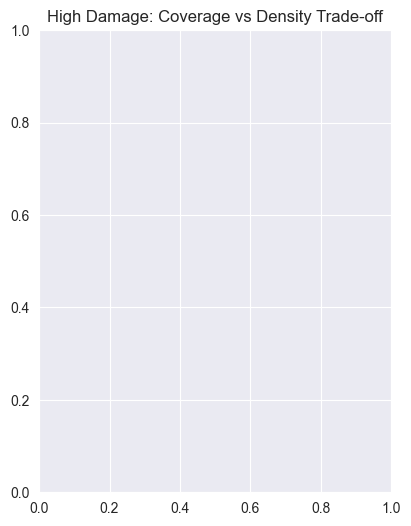

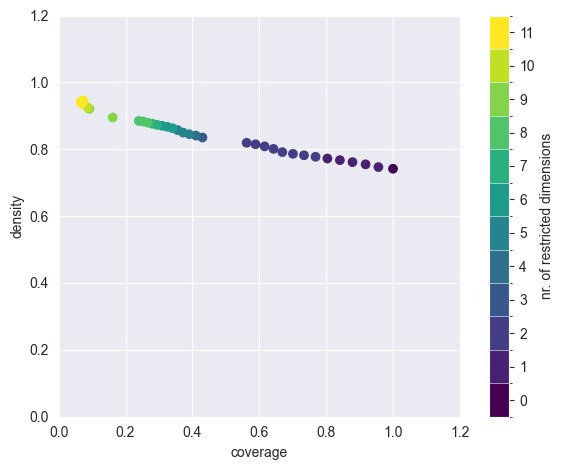

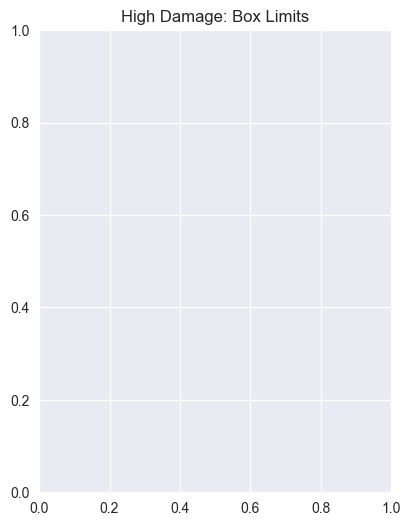

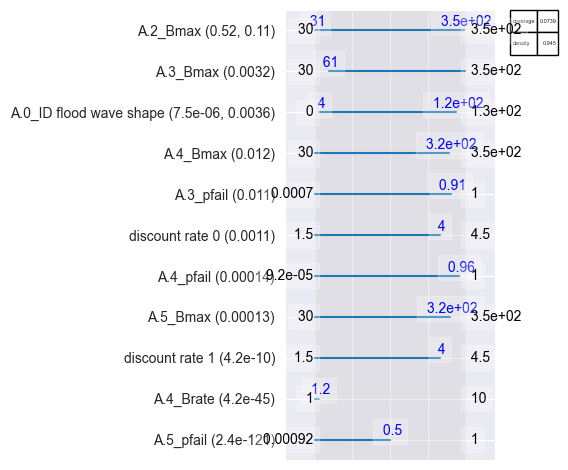

\nHigh Deaths PRIM Box:


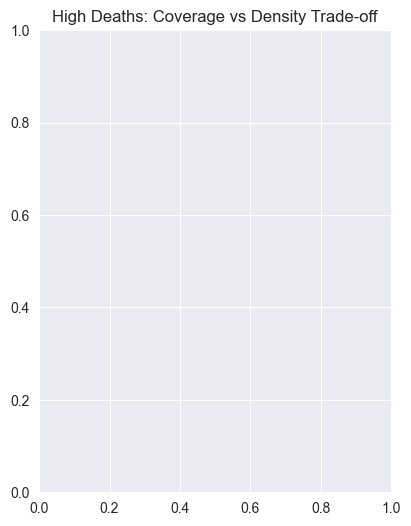

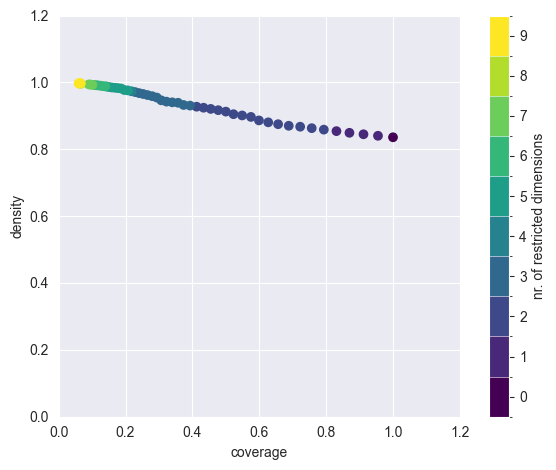

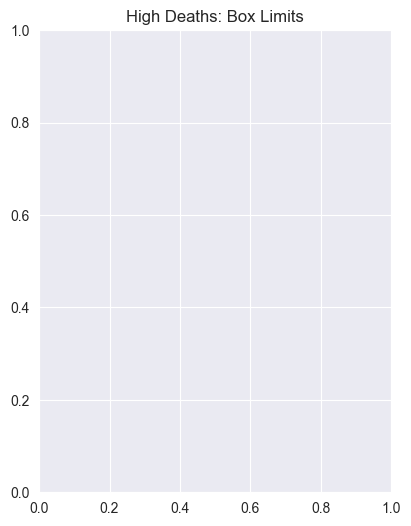

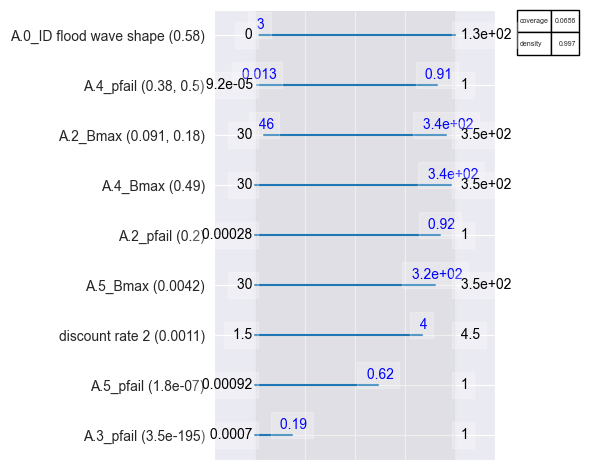

\nPRIM Box Analysis - High Damage Scenarios:
Coverage: 0.074
Density: 0.945
Box limits:
  Box limits available: 38 boxes
\nPRIM Box Analysis - High Deaths Scenarios:
Coverage: 0.066
Density: 0.997
Box limits:
  Box limits available: 58 boxes
\nSelected 4640 vulnerable scenarios from PRIM box


In [22]:
# Visualize PRIM results
print("Creating PRIM visualizations...")

# High damage PRIM results
print("\\nHigh Damage PRIM Box:")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('High Damage: Coverage vs Density Trade-off')
try:
    box_damage.show_tradeoff()  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create tradeoff plot: {e}")
    plt.close()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)  
plt.title('High Damage: Box Limits')
try:
    box_damage.inspect(style='graph')  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create inspection plot: {e}")
    plt.close()

# High deaths PRIM results
print("\\nHigh Deaths PRIM Box:")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('High Deaths: Coverage vs Density Trade-off')
try:
    box_deaths.show_tradeoff()  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create tradeoff plot: {e}")
    plt.close()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)
plt.title('High Deaths: Box Limits') 
try:
    box_deaths.inspect(style='graph')  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create inspection plot: {e}")
    plt.close()

# Print PRIM box details
print("\\nPRIM Box Analysis - High Damage Scenarios:")
try:
    print(f"Coverage: {box_damage.coverage:.3f}")
    print(f"Density: {box_damage.density:.3f}")
    
    # Try different ways to access box limits
    print("Box limits:")
    try:
        # Method 1: Try .limits attribute
        for var, (lower, upper) in box_damage.limits.items():
            print(f"  {var}: [{lower:.3f}, {upper:.3f}]")
    except AttributeError:
        try:
            # Method 2: Try .box_lims attribute
            if hasattr(box_damage, 'box_lims'):
                print(f"  Box limits available: {len(box_damage.box_lims)} boxes")
            else:
                print("  Box limits format not accessible in this version")
        except:
            print("  Could not access box limit details")
            
except Exception as e:
    print(f"Could not access high damage PRIM box details: {e}")

print("\\nPRIM Box Analysis - High Deaths Scenarios:")
try:
    print(f"Coverage: {box_deaths.coverage:.3f}")
    print(f"Density: {box_deaths.density:.3f}")
    
    # Try different ways to access box limits
    print("Box limits:")
    try:
        # Method 1: Try .limits attribute
        for var, (lower, upper) in box_deaths.limits.items():
            print(f"  {var}: [{lower:.3f}, {upper:.3f}]")
    except AttributeError:
        try:
            # Method 2: Try .box_lims attribute
            if hasattr(box_deaths, 'box_lims'):
                print(f"  Box limits available: {len(box_deaths.box_lims)} boxes")
            else:
                print("  Box limits format not accessible in this version")
        except:
            print("  Could not access box limit details")
            
except Exception as e:
    print(f"Could not access high deaths PRIM box details: {e}")

# Select representative scenarios for Multi-Scenario MORDM
# Extract scenarios within the high damage box
try:
    vulnerable_scenario_indices = box_damage.yi
    vulnerable_scenarios = experiments_for_prim.iloc[vulnerable_scenario_indices]
    print(f"\\nSelected {len(vulnerable_scenarios)} vulnerable scenarios from PRIM box")
except Exception as e:
    print(f"\\nCould not extract scenarios from PRIM box: {e}")
    print("Using alternative approach: selecting scenarios with highest damage")
    
    # Fallback: Use scenarios with highest damage as vulnerable scenarios
    damage_values = outcomes_robust.get('Expected Annual Damage', outcomes_robust[list(outcomes_robust.keys())[0]])
    top_damage_indices = np.argsort(damage_values)[-min(10, len(damage_values)):]  # Top 10 or all available
    vulnerable_scenarios = experiments_for_prim.iloc[top_damage_indices]
    print(f"Selected {len(vulnerable_scenarios)} high-damage scenarios as fallback")


## Phase 5: Multi-Scenario MORDM Setup

This phase extends the analysis to Multi-Scenario MORDM by selecting representative scenarios and preparing for optimization across multiple futures.


In [23]:
# Multi-Scenario MORDM: Select representative scenarios
import sys
import os
sys.path.append(os.path.join('..', 'Week 5-6 - robustness and direct search'))
from assignment_10_scenario_selection import find_maxdiverse_scenarios, evaluate_diversity_single
import itertools
from scipy.spatial.distance import pdist, squareform

# Select 4-5 diverse scenarios from vulnerable scenarios
n_selected_scenarios = 4

if len(vulnerable_scenarios) > n_selected_scenarios:
    # Calculate distances between scenarios
    scenario_matrix = vulnerable_scenarios.values
    distances = squareform(pdist(scenario_matrix, metric='euclidean'))
    
    # Check if combination space is manageable
    from math import comb
    n_scenarios = len(vulnerable_scenarios)
    total_combinations = comb(n_scenarios, n_selected_scenarios)
    
    print(f"Total possible combinations: {total_combinations}")
    
    if total_combinations > 10000:  # Limit to prevent memory issues
        print("Too many combinations for exhaustive search. Using random sampling approach...")
        
        # Random sampling approach for large combination spaces
        np.random.seed(42)  # For reproducibility
        best_diversity = -1
        best_combination = None
        
        # Sample 1000 random combinations instead of all combinations
        n_samples = min(1000, total_combinations)
        for _ in range(n_samples):
            random_indices = np.random.choice(n_scenarios, n_selected_scenarios, replace=False)
            diversity = evaluate_diversity_single(random_indices, distances)
            if diversity[0] > best_diversity:
                best_diversity = diversity[0]
                best_combination = random_indices
        
        selected_scenarios = vulnerable_scenarios.iloc[best_combination]
        print(f"Selected scenarios using random sampling (diversity: {best_diversity:.3f})")
        
    else:
        print("Using exhaustive search for scenario combinations...")
        # Original exhaustive approach for smaller combination spaces
        scenario_combinations = list(itertools.combinations(range(len(vulnerable_scenarios)), n_selected_scenarios))
        scores = find_maxdiverse_scenarios(distances, scenario_combinations)
        
        # Select best combination (highest diversity)
        best_combination = max(scores, key=lambda x: x[0])[1]
        selected_scenarios = vulnerable_scenarios.iloc[list(best_combination)]
        print(f"Selected scenarios using exhaustive search (diversity: {max(scores, key=lambda x: x[0])[0][0]:.3f})")

else:
    # Use all available scenarios if we have fewer than desired
    selected_scenarios = vulnerable_scenarios
    best_combination = list(range(len(vulnerable_scenarios)))
    print(f"Using all {len(vulnerable_scenarios)} available scenarios (fewer than requested {n_selected_scenarios})")

print(f"Multi-Scenario MORDM Setup:")
print(f"- Selected {len(selected_scenarios)} scenarios from {len(vulnerable_scenarios)} vulnerable scenarios")
print(f"- Scenario selection method: Diversity maximization")

# Convert selected scenarios to Scenario objects for optimization
selected_scenario_objects = []
for i, (idx, scenario_row) in enumerate(selected_scenarios.iterrows()):
    scenario_dict = scenario_row.to_dict()
    scenario_name = f"Vulnerable_Scenario_{i+1}"
    selected_scenario_objects.append(Scenario(scenario_name, **scenario_dict))

print(f"- Created {len(selected_scenario_objects)} Scenario objects")

# Display scenario characteristics
print("\\nSelected Scenario Characteristics:")
print(selected_scenarios.describe())


Total possible combinations: 19288522037240
Too many combinations for exhaustive search. Using random sampling approach...
Selected scenarios using random sampling (diversity: 327.842)
Multi-Scenario MORDM Setup:
- Selected 4 scenarios from 4640 vulnerable scenarios
- Scenario selection method: Diversity maximization
- Created 4 Scenario objects
\nSelected Scenario Characteristics:
       A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail    A.2_Bmax  \
count                  4.00000    4.000000      4.000   4.000000    4.000000   
mean                  71.50000  205.536414      1.375   0.319828  151.733447   
std                   44.15503  144.685090      0.250   0.166024  113.543471   
min                    8.00000   76.614805      1.000   0.186887   31.146741   
25%                   58.25000   82.102403      1.375   0.222491   87.363638   
50%                   87.50000  206.189231      1.500   0.266636  138.380951   
75%                  100.75000  329.623241      1.500  

In [25]:
# Multi-Scenario MORDM: Select representative scenarios
import sys
import os
sys.path.append(os.path.join('..', 'Week 5-6 - robustness and direct search'))
from assignment_10_scenario_selection import find_maxdiverse_scenarios, evaluate_diversity_single
import itertools
from scipy.spatial.distance import pdist, squareform

# Select 4-5 diverse scenarios from vulnerable scenarios
n_selected_scenarios = 4

if len(vulnerable_scenarios) > n_selected_scenarios:
    # Calculate distances between scenarios
    scenario_matrix = vulnerable_scenarios.values
    distances = squareform(pdist(scenario_matrix, metric='euclidean'))
    
    # Check if combination space is manageable
    from math import comb
    n_scenarios = len(vulnerable_scenarios)
    total_combinations = comb(n_scenarios, n_selected_scenarios)
    
    print(f"Total possible combinations: {total_combinations}")
    
    if total_combinations > 10000:  # Limit to prevent memory issues
        print("Too many combinations for exhaustive search. Using random sampling approach...")
        
        # Random sampling approach for large combination spaces
        np.random.seed(42)  # For reproducibility
        best_diversity = -1
        best_combination = None
        
        # Sample 1000 random combinations instead of all combinations
        n_samples = min(1000, total_combinations)
        for _ in range(n_samples):
            random_indices = np.random.choice(n_scenarios, n_selected_scenarios, replace=False)
            diversity = evaluate_diversity_single(random_indices, distances)
            if diversity[0] > best_diversity:
                best_diversity = diversity[0]
                best_combination = random_indices
        
        selected_scenarios = vulnerable_scenarios.iloc[best_combination]
        print(f"Selected scenarios using random sampling (diversity: {best_diversity:.3f})")
        
    else:
        print("Using exhaustive search for scenario combinations...")
        # Original exhaustive approach for smaller combination spaces
        scenario_combinations = list(itertools.combinations(range(len(vulnerable_scenarios)), n_selected_scenarios))
        scores = find_maxdiverse_scenarios(distances, scenario_combinations)
        
        # Select best combination (highest diversity)
        best_combination = max(scores, key=lambda x: x[0])[1]
        selected_scenarios = vulnerable_scenarios.iloc[list(best_combination)]
        print(f"Selected scenarios using exhaustive search (diversity: {max(scores, key=lambda x: x[0])[0][0]:.3f})")

else:
    # Use all available scenarios if we have fewer than desired
    selected_scenarios = vulnerable_scenarios
    best_combination = list(range(len(vulnerable_scenarios)))
    print(f"Using all {len(vulnerable_scenarios)} available scenarios (fewer than requested {n_selected_scenarios})")

print(f"Multi-Scenario MORDM Setup:")
print(f"- Selected {len(selected_scenarios)} scenarios from {len(vulnerable_scenarios)} vulnerable scenarios")
print(f"- Scenario selection method: Diversity maximization")

# Convert selected scenarios to Scenario objects for optimization
selected_scenario_objects = []
for i, (idx, scenario_row) in enumerate(selected_scenarios.iterrows()):
    scenario_dict = scenario_row.to_dict()
    scenario_name = f"Vulnerable_Scenario_{i+1}"
    selected_scenario_objects.append(Scenario(scenario_name, **scenario_dict))

print(f"- Created {len(selected_scenario_objects)} Scenario objects")

# Display scenario characteristics
print("\\nSelected Scenario Characteristics:")
print(selected_scenarios.describe())


Total possible combinations: 19288522037240
Too many combinations for exhaustive search. Using random sampling approach...
Selected scenarios using random sampling (diversity: 327.842)
Multi-Scenario MORDM Setup:
- Selected 4 scenarios from 4640 vulnerable scenarios
- Scenario selection method: Diversity maximization
- Created 4 Scenario objects
\nSelected Scenario Characteristics:
       A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail    A.2_Bmax  \
count                  4.00000    4.000000      4.000   4.000000    4.000000   
mean                  71.50000  205.536414      1.375   0.319828  151.733447   
std                   44.15503  144.685090      0.250   0.166024  113.543471   
min                    8.00000   76.614805      1.000   0.186887   31.146741   
25%                   58.25000   82.102403      1.375   0.222491   87.363638   
50%                   87.50000  206.189231      1.500   0.266636  138.380951   
75%                  100.75000  329.623241      1.500  

In [26]:
selected_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
23081,75,328.446859,1.5,0.234359,31.146741,1.5,0.421588,228.740480,1.0,0.746655,41.585862,1.0,0.730063,64.211211,1.0,0.033865,1.5,3.5,1.5
60078,8,333.152389,1.0,0.186887,106.102604,1.5,0.174360,291.874265,10.0,0.204151,302.670230,1.0,0.927945,160.656153,10.0,0.201063,3.5,2.5,1.5
77878,103,76.614805,1.5,0.298913,170.659297,10.0,0.950629,194.122938,10.0,0.149554,98.753666,1.0,0.810648,33.484741,1.5,0.105335,3.5,2.5,4.5
69447,100,83.931603,1.5,0.559152,299.025144,1.5,0.278103,197.844788,10.0,0.156167,110.006812,1.0,0.710430,302.753990,1.0,0.337700,3.5,2.5,4.5


In [27]:
selected_scenarios.to_csv('selected_scenarios.csv', index=False)

### optimization of the 4 selected scenarios (results saved do not run again)

In [14]:
# Enable logging to view progress
ema_logging.log_to_stderr(ema_logging.INFO)

# Load your selected scenarios (from saved CSV if needed)
selected_scenarios_df = pd.read_csv("selected_scenarios.csv")
selected_scenario_objects = []

# Rebuild scenario objects from DataFrame
for i, row in selected_scenarios_df.iterrows():
    scenario_name = f"Scenario_{i+1}"
    selected_scenario_objects.append(Scenario(scenario_name, **row.to_dict()))

# Optimization setup
def optimize(scenario, nfe, dike_model, epsilons):
    with MultiprocessingEvaluator(dike_model) as evaluator:
        convergence_metrics = [
            ArchiveLogger(
                "./results",
                [lever.name for lever in dike_model.levers],
                [outcome.name for outcome in dike_model.outcomes],
                base_filename=f"MS-MORDM_0.25_10000_{scenario.name}.tar.gz",
            ),
            EpsilonProgress()
        ]

        result, convergence = evaluator.optimize(
            nfe=nfe,
            searchover='levers',
            convergence=convergence_metrics,
            epsilons=epsilons,
            reference=scenario
        )
        
        return result, convergence

# Set optimization parameters
nfe = 10000
epsilons = [0.25] * len(dike_model.outcomes)  # Adjust as needed

# Run optimization for each scenario
results = []
for scenario in selected_scenario_objects:
    results.append(optimize(scenario, nfe, dike_model, epsilons))

# Save results
for i, (archive, convergence) in enumerate(results):
    archive.to_csv(f'./results/MS-MORDM_0.25_10000_archive_scen{i}.csv')
    convergence.to_csv(f'./results/MS-MORDM_0.25_10000_convergence_scen{i}.csv')

[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████| 10000/10000 [07:51<00:00, 21.22it/s]
[MainProcess/INFO] optimization completed, found 297 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████| 10000/10000 [07:31<00:00, 22.15it/s]
[MainProcess/INFO] optimization completed, found 274 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████| 10000/10000 [06:55<00:00, 24.10it/s]
[MainProcess/INFO] optimization completed, found 288 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████| 10000/10000 [06:52<00:00, 24.23it/s]
[MainProcess/INFO] optimization completed, found 199 solutions
[MainProcess/INFO] terminating pool


### extract and filter policies (you can run this again)

In [3]:
# Load your selected scenarios (from saved CSV if needed)
selected_scenarios_df = pd.read_csv("selected_scenarios.csv")


# Optional: Extract and filter policies based on performance 
policies = []
for i in range(len(selected_scenarios_df)):
    archive = pd.read_csv(f'./results/MS-MORDM_0.25_10000_archive_scen{i}.csv', index_col=0)
    
    # Subset of policies with better-than-median outcomes (changed this to quantile but up to u)
    sub = archive[
        (archive['Expected Number of Deaths'] < archive['Expected Number of Deaths'].quantile(0.10)) &
        (archive['Expected Annual Damage'] < archive['Expected Annual Damage'].quantile(0.10))
    ]
    
    # Extract policy levers only (exclude outcome columns)
    policy_levers = sub.iloc[:, :-5]  # Adjust if you have more/fewer outcomes
    for j, row in policy_levers.iterrows():
        policies.append(Policy(f"Scenario_{i+1}_Option_{j}", **row.to_dict()))

# You can now use `policies` for robustness evaluation or further analysis

In [4]:
policies

[Policy({'0_RfR 0': 1, '0_RfR 1': 1, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 1, '2_RfR 2': 1, '3_RfR 0': 0, '3_RfR 1': 1, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 2, 'A.3_DikeIncrease 2': 1, 'A.4_DikeIncrease 0': 1, 'A.4_DikeIncrease 1': 6, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 8, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 4, 'A.1_DikeIncrease 1': 1, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

In [5]:
print("Number of policies for Multi_MORDM: ",len(policies))

Number of policies for Multi_MORDM:  83


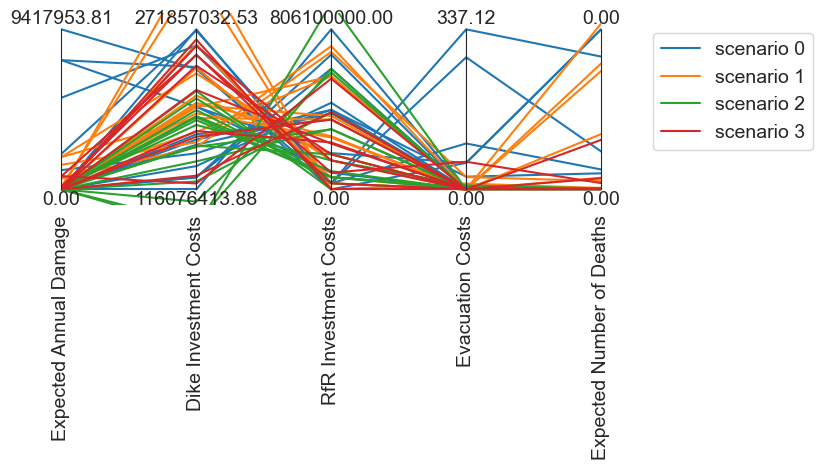

In [6]:
colors = iter(sns.color_palette())

result = pd.read_csv('./results/MS-MORDM_0.25_10000_archive_scen'+str(0)+'.csv', header=[0], index_col=[0])
result_subspace = result.loc[result['Expected Number of Deaths'] < result['Expected Number of Deaths'].quantile(0.10)]
result_subspace = result_subspace.loc[result_subspace['Expected Annual Damage'] < result_subspace['Expected Annual Damage'].median()]
#result_subspace = result_subspace.loc[result_subspace['Dike Investment Costs'] < result_subspace['Dike Investment Costs'].median()]
#result_subspace = result_subspace.loc[result_subspace['RfR Investment Costs'] < result_subspace['RfR Investment Costs'].median()]
data = result_subspace.iloc[:, -5::]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)

# Load your selected scenarios (from saved CSV if needed)
selected_scenarios_df = pd.read_csv("selected_scenarios.csv")
selected_scenario_objects = []

for i in range(len(selected_scenarios_df)):
    color = next(colors)
    result = pd.read_csv('./results/MS-MORDM_0.25_10000_archive_scen'+str(i)+'.csv', header=[0], index_col=[0])
    result_subspace = result.loc[result['Expected Number of Deaths'] < result['Expected Number of Deaths'].quantile(0.10)]
    result_subspace = result_subspace.loc[result_subspace['Expected Annual Damage'] < result_subspace['Expected Annual Damage'].median()]
    #result_subspace = result_subspace.loc[result_subspace['Dike Investment Costs'] < result_subspace['Dike Investment Costs'].median()]
    #result_subspace = result_subspace.loc[result_subspace['RfR Investment Costs'] < result_subspace['RfR Investment Costs'].median()]
    data = result_subspace.iloc[:, -5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
#plt.savefig('./Multi-scenario_MORDM/plots/MS-MORDM_0.25_10000_parcoord_subDeathsDamage.png', dpi=300, bbox_inches='tight')
plt.show()

### Reevaluation under deep uncertainty
Reevaluate policies under deep uncertainty over 100 scenarios (due to limtied computing power)

In [ ]:
experiments, outcomes = reevaluation_results
save_results(reevaluation_results, './results/MS-MORDM_reevaluation_0.25_100scen.tar.gz'.format(nfe))

In [ ]:
reevaluation_results = load_results('./results/MS-MORDM_reevaluation_0.25_100scen_old.tar.gz')
experiments, outcomes = reevaluation_results

## Phase 6: Global Sensitivity Analysis (SOBOL)

We perform SOBOL sensitivity analysis to identify which uncertainties most significantly influence the model outcomes.


In [ ]:
# SOBOL Global Sensitivity Analysis (Robust Implementation)
print(f"Performing SOBOL sensitivity analysis with {n_sobol_samples} base samples...")

# Calculate expected number of experiments
n_uncertainties = len(dike_model.uncertainties)
expected_experiments = n_sobol_samples * (2 * n_uncertainties + 2)
print(f"Expected number of experiments: {expected_experiments}")
print(f"Number of uncertainties: {n_uncertainties}")

# Use SequentialEvaluator for stability (like in Week 3-4 assignments)
print("Using SequentialEvaluator for stability with complex dike model...")

try:
    # Run SOBOL experiments with sequential evaluation for stability
    with SequentialEvaluator(dike_model) as evaluator:
        sobol_results = evaluator.perform_experiments(
            scenarios=n_sobol_samples,
            uncertainty_sampling=Samplers.SOBOL
        )
    
    sobol_experiments, sobol_outcomes = sobol_results
    print(f"✓ SOBOL experiments completed with {len(sobol_experiments)} runs")
    
    # Save the experimental results immediately
    save_results(sobol_results, f'IJssel_SOBOL_results_n{n_sobol_samples}.tar.gz')
    print(f"✓ Saved SOBOL experimental results to IJssel_SOBOL_results_n{n_sobol_samples}.tar.gz")
    
    # Get SALib problem formulation for analysis
    sa_problem = get_SALib_problem(dike_model.uncertainties)
    print(f"✓ Created SALib problem with {sa_problem['num_vars']} variables")
    
    # Perform SOBOL analysis for each outcome
    sobol_indices = {}
    outcome_names = [outcome.name for outcome in dike_model.outcomes]
    
    print(f"\\nAnalyzing {len(outcome_names)} outcomes...")
    for i, outcome_name in enumerate(outcome_names):
        print(f"  {i+1}/{len(outcome_names)}: Analyzing {outcome_name}...")
        
        # Get model outputs for this outcome
        if isinstance(sobol_outcomes[outcome_name], list):
            Y = np.array(sobol_outcomes[outcome_name])
        else:
            Y = sobol_outcomes[outcome_name].values if hasattr(sobol_outcomes[outcome_name], 'values') else sobol_outcomes[outcome_name]
        
        # Handle different outcome array shapes
        if Y.ndim > 1:
            Y = Y.flatten()
        
        # Remove NaN values for SOBOL analysis
        Y_clean = Y[~np.isnan(Y)]
        if len(Y_clean) < len(Y):
            print(f"    Warning: Removed {len(Y) - len(Y_clean)} NaN values")
        
        if len(Y_clean) < expected_experiments * 0.8:  # Less than 80% valid data
            print(f"    Warning: Only {len(Y_clean)} valid samples out of {expected_experiments}")
        
        # Compute SOBOL indices (following Week 3-4 pattern)
        try:
            Si = sobol.analyze(sa_problem, Y_clean, calc_second_order=True, print_to_console=False)
            sobol_indices[outcome_name] = Si
            print(f"    ✓ Analysis complete")
        except Exception as e:
            print(f"    ✗ Failed to analyze {outcome_name}: {str(e)}")
            sobol_indices[outcome_name] = None
    
    print("\\n✓ SOBOL analysis completed")
    
    # Save the SOBOL indices results
    import pickle
    with open(f'IJssel_SOBOL_indices_n{n_sobol_samples}.pkl', 'wb') as f:
        pickle.dump(sobol_indices, f)
    print(f"✓ Saved SOBOL indices to IJssel_SOBOL_indices_n{n_sobol_samples}.pkl")
    
    # Create summary table (only for successful analyses)
    summary_data = []
    successful_outcomes = [name for name, indices in sobol_indices.items() if indices is not None]
    
    for outcome_name in successful_outcomes:
        Si = sobol_indices[outcome_name]
        uncertainty_names = sa_problem['names']
        
        for i, uncertainty in enumerate(uncertainty_names):
            summary_data.append({
                'Outcome': outcome_name,
                'Uncertainty': uncertainty,
                'S1': Si['S1'][i],
                'S1_conf': Si['S1_conf'][i],
                'ST': Si['ST'][i],
                'ST_conf': Si['ST_conf'][i]
            })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(f'IJssel_SOBOL_summary_n{n_sobol_samples}.csv', index=False)
    print(f"✓ Saved SOBOL summary table to IJssel_SOBOL_summary_n{n_sobol_samples}.csv")
    
    # Visualize SOBOL indices (following Week 3-4 pattern)
    n_successful = len(successful_outcomes)
    if n_successful > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, outcome_name in enumerate(successful_outcomes[:6]):  # Show first 6 outcomes
            if i < len(axes):
                ax = axes[i]
                
                # Extract first-order indices (following Week 3-4 style)
                S1 = sobol_indices[outcome_name]['S1']
                ST = sobol_indices[outcome_name]['ST']
                S1_conf = sobol_indices[outcome_name]['S1_conf']
                ST_conf = sobol_indices[outcome_name]['ST_conf']
                
                # Create DataFrame for easier plotting (like Week 3-4)
                indices_df = pd.DataFrame({
                    'S1': S1,
                    'ST': ST
                }, index=sa_problem['names'])
                
                err_df = pd.DataFrame({
                    'S1_conf': S1_conf,
                    'ST_conf': ST_conf
                }, index=sa_problem['names'])
                
                # Plot like in Week 3-4 assignments
                indices_df.plot.bar(yerr=err_df.values.T, ax=ax, capsize=3, alpha=0.7)
                ax.set_title(f'SOBOL Indices: {outcome_name}', fontsize=10)
                ax.set_xlabel('Uncertainties')
                ax.set_ylabel('Sensitivity Index')
                ax.tick_params(axis='x', rotation=45)
                ax.grid(True, alpha=0.3)
                ax.legend(['First-order (S1)', 'Total-order (ST)'])
        
        # Remove empty subplots
        for i in range(n_successful, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
        
        # Print top sensitive uncertainties for each outcome (like Week 3-4)
        print("\\nTop 3 Most Influential Uncertainties by Outcome:")
        for outcome_name in successful_outcomes:
            ST = sobol_indices[outcome_name]['ST']  # Use total-order indices
            uncertainty_names = sa_problem['names']
            
            # Get top 3 uncertainties
            top_indices = np.argsort(ST)[-3:][::-1]
            
            print(f"\\n{outcome_name}:")
            for j, idx in enumerate(top_indices):
                print(f"  {j+1}. {uncertainty_names[idx]}: ST = {ST[idx]:.3f}")
    else:
        print("No successful SOBOL analyses to visualize")

except Exception as e:
    print(f"✗ SOBOL analysis failed: {str(e)}")
    print("\\nTroubleshooting suggestions:")
    print("1. Try reducing n_sobol_samples (e.g., to 32 or 16)")
    print("2. Check if the dike model runs correctly with a small sample")
    print("3. Consider using MultiprocessingEvaluator with n_processes=2")
    
    # Provide fallback option
    print("\\nAttempting fallback with smaller sample size...")
    fallback_samples = min(16, n_sobol_samples // 4)
    try:
        with SequentialEvaluator(dike_model) as evaluator:
            fallback_results = evaluator.perform_experiments(
                scenarios=fallback_samples,
                uncertainty_sampling=Samplers.SOBOL
            )
        print(f"✓ Fallback succeeded with {fallback_samples} samples")
        print("Consider running the full analysis with this smaller sample size")
    except Exception as fallback_error:
        print(f"✗ Fallback also failed: {str(fallback_error)}")

print("\\nSOBOL Analysis Phase Complete!")


Performing SOBOL sensitivity analysis with 64 base samples...
Running SOBOL experiments using EMA Workbench...


[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 2560 scenarios * 1 policies * 1 model(s) = 2560 experiments
  0%|                                                 | 0/2560 [00:00<?, ?it/s]

In [ ]:
# Optional: Load existing SOBOL results (uncomment if restarting notebook)
# This cell allows you to load previously saved results instead of re-running the analysis

# Uncomment these lines if you want to load existing results:
# import pickle
# from ema_workbench import load_results

# # Load experimental results
# sobol_results = load_results(f'IJssel_SOBOL_results_n{n_sobol_samples}.tar.gz')
# sobol_experiments, sobol_outcomes = sobol_results
# print(f"✓ Loaded SOBOL experimental results with {len(sobol_experiments)} runs")

# # Load SOBOL indices
# with open(f'IJssel_SOBOL_indices_n{n_sobol_samples}.pkl', 'rb') as f:
#     sobol_indices = pickle.load(f)
# print(f"✓ Loaded SOBOL indices for {len(sobol_indices)} outcomes")

# # Get SALib problem formulation for analysis
# sa_problem = get_SALib_problem(dike_model.uncertainties)
# outcome_names = [outcome.name for outcome in dike_model.outcomes]

# print("Ready to proceed with visualization and analysis!")
